*Created by Emma Yang*

This notebook covers the full machine learning pipeline from data preprocessing to feature engineering and to modeling--prediction.The results achieve over **87%** accuracy in predicting good vs bad loans.



**GAP (Why am I doing this):**


> Fatal Flaws:
> *   Poor modeling results  (for example, what we are most concerned about is recall, which is the proportion of real bad loans that are identified. Although some notebook had a high ROC, the recall might not be satisfactory)
> *   Wrong classification of good and bad loans from the start in some notebook

> Insufficiency:
> *   incomplete data cleaning
> *   insufficient model exploration

Hope you enjoy~

# Content
- [Import and read data](#Import-and-read-data)
- [EDA Automation](#EDA-Automation)
- [Data Cleaning](#Data-Cleaning)
  - [Removing exclusions](#Removing-exclusions)
  - [Missing Value Imputation](#Missing-Value-Imputation)
  - [Removing Outlier](#Removing-Outlier)
- [Correlation Analysis](#Correlation-Analysis)
- [Feature Engineering](#Feature-Engineering)
  - [Binary Encoding for Binary Variables](#Binary-Encoding)
  - [Target Encoding for Multicategorical Variables](#Target-Encoding)
  - [Normalization for Numeric Variables](#Normalization)
- [Dealing with Imbalanced Dataset](#Dealing-with-Imbalanced-Dataset)
- [Feature Selection](#Feature-Selection)
- [Model Building](#Model-Building)
- [Model Evaluation on Hold-Out Set](#Model-Evaluation)




<a name="Import-and-read-data"></a>
# Import and read data


In [ ]:
!pip install category_encoders

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
start_time = datetime.now()


import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 8,6


# Plotly visualizations
from plotly import tools
# import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.offline as pyo
import plotly.express as px
init_notebook_mode(connected=True)

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# For undersamping
from imblearn.under_sampling import RandomUnderSampler

# for encoding and normalization
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold

# import lightgbm as lgb
import math
import itertools as it
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Other machine learning tools

from sklearn.feature_selection import RFECV
import scipy.stats as sps

from sklearn.ensemble import BaggingClassifier

print('LOADING DURATION: ', datetime.now() - start_time)


pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

LOADING DURATION:  0:00:19.159608


# Import and read data

In [ ]:
df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

df = df.dropna(subset=["loan_status"])
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#reduce the data size to fasten following steps, otherwise the memory will soon run out
complete_df = df.sample(n=100000, random_state=42)

In [ ]:
# Add necessary variables
# Determining the loans that are bad from loan_status column --dependent variable (y)
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]
complete_df['loan_condition_int'] = complete_df['loan_status'].apply(lambda status: 1 if status in bad_loan else 0).astype(int)
complete_df['loan_condition'] = np.where(complete_df['loan_condition_int'] == 0, 'Good Loan', 'Bad Loan')

#emp_length
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}
complete_df['emp_length_int'] = complete_df['emp_length'].map(emp_length_mapping)
complete_df.head().transpose()

# region
state_to_region = {
    'CA': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'CO': 'West',
    'NV': 'West', 'AK': 'West', 'MT': 'West', 'HI': 'West', 'WY': 'West', 'ID': 'West',
    'AZ': 'SouthWest', 'TX': 'SouthWest', 'NM': 'SouthWest', 'OK': 'SouthWest',
    'GA': 'SouthEast', 'NC': 'SouthEast', 'VA': 'SouthEast', 'FL': 'SouthEast', 'KY': 'SouthEast',
    'SC': 'SouthEast', 'LA': 'SouthEast', 'AL': 'SouthEast', 'WV': 'SouthEast', 'DC': 'SouthEast',
    'AR': 'SouthEast', 'DE': 'SouthEast', 'MS': 'SouthEast', 'TN': 'SouthEast',
    'IL': 'MidWest', 'MO': 'MidWest', 'MN': 'MidWest', 'OH': 'MidWest', 'WI': 'MidWest',
    'KS': 'MidWest', 'MI': 'MidWest', 'SD': 'MidWest', 'IA': 'MidWest', 'NE': 'MidWest',
    'IN': 'MidWest', 'ND': 'MidWest',
    'CT': 'NorthEast', 'NY': 'NorthEast', 'PA': 'NorthEast', 'NJ': 'NorthEast', 'RI': 'NorthEast',
    'MA': 'NorthEast', 'MD': 'NorthEast', 'VT': 'NorthEast', 'NH': 'NorthEast', 'ME': 'NorthEast'
}
complete_df['region'] = complete_df['addr_state'].map(state_to_region)
complete_df.head().transpose()

,1758074,686539,900731,1727935,539695
id,9785323,78558461,110757806,96668860,118207599
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,28000.0,10650.0,18000.0,3975.0,4800.0
funded_amnt,28000.0,10650.0,18000.0,3975.0,4800.0
funded_amnt_inv,28000.0,10650.0,18000.0,3975.0,4800.0
...,...,...,...,...,...
settlement_term,NaN,NaN,NaN,NaN,NaN
loan_condition_int,0,0,0,0,0
loan_condition,Good Loan,Good Loan,Good Loan,Good Loan,Good Loan
emp_length_int,10.0,10.0,9.0,2.0,0.5


# EDA Automation
The following is an EDA(Exploratory Data Analysis) Automation.

The code allows for flexible variable selection, enabling more in-depth business insights to be gained.

**instruction:**
With designed functions, you can quickly plot by entering variables name (the corresponding variable can be selected in the corresponding comment behind the variable). If you run the code in Colab, you can directly select the variable through the drop-down. If not,

In [ ]:
EDA_df = complete_df.copy()

EDA_cat_columns = EDA_df.select_dtypes(include=['object']).columns.tolist()
EDA_num_columns = EDA_df.select_dtypes(exclude=['object']).columns.tolist()

# Filter categorical columns with unique value count less than or equal to the specified threshold.
filtered_EDA_cat_columns = [col for col in EDA_cat_columns if EDA_df[col].nunique() <= 50]

In [ ]:
def plot_variable_distribution(dataframe, variable_name):
    if dataframe[variable_name].dtype == 'object':
        # Categorical variables, draw a histogram
        sns.countplot(x=variable_name, data=dataframe)
        plt.xlabel(variable_name)
        plt.ylabel('Count')
        plt.title(f'Distribution of {variable_name}')
    else:
        # Numeric variables, plot histograms
        sns.histplot(dataframe[variable_name], kde=True)
        plt.xlabel(variable_name)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {variable_name}')
    plt.show()

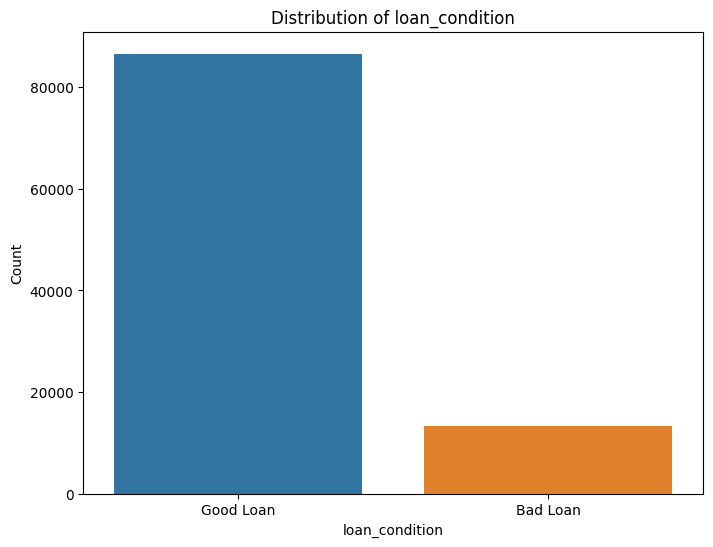

In [ ]:
variable = "loan_condition" # @param ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'loan_condition_int', 'loan_condition', 'emp_length_int', 'region'] {allow-input: true}
plot_variable_distribution(EDA_df, variable)

In [ ]:
def plot_2_variable_relationship(dataframe, x_variable, y_variable):
    if dataframe[x_variable].dtype != 'object' and dataframe[y_variable].dtype != 'object':
        # Two numerical variables, draw a scatter plot
        sns.scatterplot(x=x_variable, y=y_variable, data=dataframe)
        plt.xlabel(x_variable)
        plt.ylabel(y_variable)
        plt.title(f'Scatter Plot: {x_variable} vs. {y_variable}')
    elif dataframe[x_variable].dtype == 'object' and dataframe[y_variable].dtype == 'object':
        # Two categorical variables, draw a crosstab
        cross_tab = pd.crosstab(index=dataframe[x_variable], columns=dataframe[y_variable], normalize='columns') #Show column summary percentage
        sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
        plt.xlabel(y_variable)
        plt.ylabel(x_variable)
        plt.title(f'Cross Tabulation: {x_variable} vs. {y_variable}')
    elif (dataframe[x_variable].dtype != 'object' and dataframe[y_variable].dtype == 'object') or (dataframe[x_variable].dtype == 'object' and dataframe[y_variable].dtype != 'object'):
        # One categorical variable, one numerical variabl"e, draw a violin plot
        if dataframe[x_variable].dtype != 'object':
            x_variable, y_variable = y_variable, x_variable  # Swap the order of the variables and make sure Y is a numeric variable
        sns.violinplot(x=x_variable, y=y_variable, data=dataframe)
        plt.xlabel(x_variable)
        plt.ylabel(y_variable)
        plt.title(f'Violin Plot: {x_variable} vs. {y_variable}')
        sns.despine()
    else:
        print("Unsupported combination of variable types")

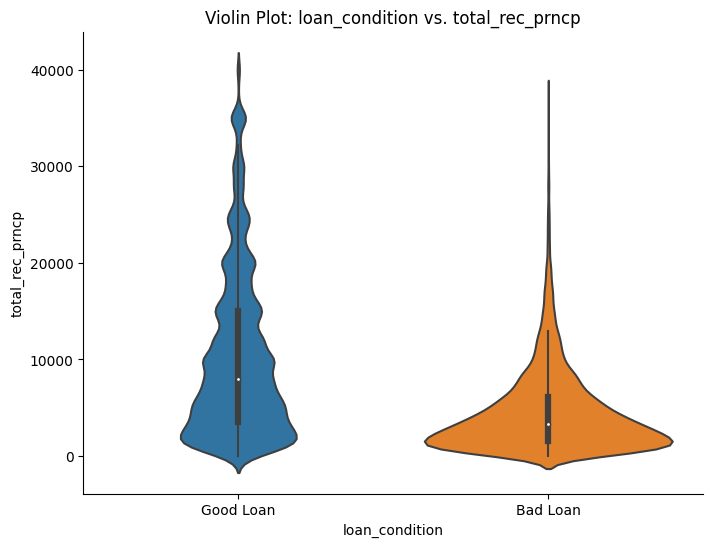

In [ ]:
X = "loan_condition"
Y = "total_rec_prncp"

plot_2_variable_relationship(EDA_df,X,Y)

In [ ]:
def plot_3_variable_relationship(dataframe, x1_variable, x2_variable, y_variable):
    num_types = ['int64', 'float64']

    if (dataframe[x1_variable].dtype == 'object' and
        dataframe[x2_variable].dtype == 'object' and
        dataframe[y_variable].dtype == 'object'):
        # Three categorical variables, draw a crosstab
        cross_tab = pd.crosstab(index=dataframe[x1_variable], columns=[dataframe[x2_variable], dataframe[y_variable]], normalize='columns')
        sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
        plt.xlabel(f'{x2_variable} - {y_variable}')
        plt.ylabel(x1_variable)
        plt.title(f'Cross Tabulation: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype == 'object' and
          dataframe[x2_variable].dtype == 'object' and
          dataframe[y_variable].dtype in num_types):
        # X1 and X2 are categorical, Y is a numerical variable, draw a violin plot or boxplot
        # Example: Drawing a Violin Plot
        sns.violinplot(x=x1_variable, y=y_variable, hue=x2_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(y_variable)
        plt.title(f'Violin Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype in num_types and
          dataframe[x2_variable].dtype in num_types and
          dataframe[y_variable].dtype == 'object'):
        # X1 and X2 are numerical variables, Y is a categorical variable, draw a box plot or violin plot
        # Example: Drawing a Violin Plot
        sns.boxplot(x=x1_variable, y=y_variable, hue=x2_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(y_variable)
        plt.title(f'Box Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype in num_types and
          dataframe[x2_variable].dtype in num_types and
          dataframe[y_variable].dtype in num_types):
        # Three numerical variables, draw a scatter plot
        sns.scatterplot(x=x1_variable, y=x2_variable, hue=y_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(x2_variable)
        plt.title(f'Scatter Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif ((dataframe[x1_variable].dtype == 'object' and dataframe[x2_variable].dtype in num_types) or
          (dataframe[x1_variable].dtype in num_types and dataframe[x2_variable].dtype == 'object')):
        # One of X1 and X2 is a categorical variable and the other is a numerical variable
        if dataframe[y_variable].dtype == 'object':
            # Y is a categorical variable, draw a boxplot or violin plot
            sns.boxplot(x=x1_variable, y=x2_variable, hue=y_variable, data=dataframe)
            plt.xlabel(x1_variable)
            plt.ylabel(x2_variable)
            plt.title(f'Box Plot: {x1_variable} vs. {x2_variable} with Color-Coded {y_variable}')
        elif dataframe[y_variable].dtype in num_types:
            # Y is a numerical variable, draw a box plot or violin plot
            sns.boxplot(x=x1_variable, y=x2_variable, data=dataframe)
            plt.xlabel(x1_variable)
            plt.ylabel(x2_variable)
            plt.title(f'Box Plot: {x1_variable} vs. {x2_variable}')
    else:
        print("Unsupported combination of variable types")


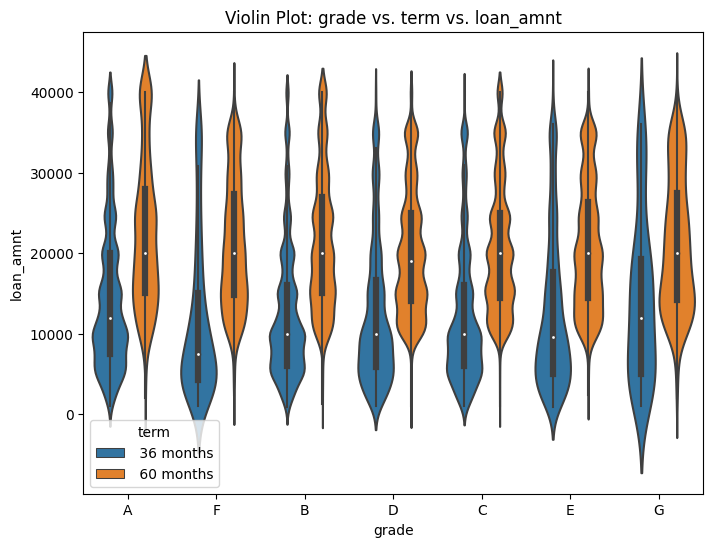

In [ ]:
X1 = "grade"
X2 = "term"
Y = "loan_amnt"

plot_3_variable_relationship(EDA_df,X1,X2,Y)

<a name="Data-Cleaning"></a>
# Data Cleaning

This part includes:


*   Removing Exclusions
*   Missing Value Imputation
*   Removing Outliers

<a name="Removing-exclusions"></a>
## Removing Exclusions

Steps:


1.   Delete `Current` and `Issued` status
(Adjustment: change the classification of good loans and bad loans)
2.   Delete variables with more than 80% missing values
2.   Delete direct indicators
1.   Delete repetitive object variable

In [ ]:
complete_df.dtypes

id                     object
member_id             float64
loan_amnt             float64
funded_amnt           float64
funded_amnt_inv       float64
                       ...   
settlement_term       float64
loan_condition_int      int64
loan_condition         object
emp_length_int        float64
region                 object
Length: 155, dtype: object

In [ ]:
pd.value_counts(complete_df.loan_status).to_frame().reset_index()

,loan_status,count
0,Fully Paid,47718
1,Current,38822
2,Charged Off,11868
3,Late (31-120 days),946
4,In Grace Period,335
5,Late (16-30 days),185
6,Does not meet the credit policy. Status:Fully ...,88
7,Does not meet the credit policy. Status:Charge...,36
8,Default,2



**1 Ajustment: change the classification of good loans and bad loans**


`Current` and `Issued` should be excluded, as they did not indicate the direction of the loans (it was unclear whether they were associated with good or bad loans).


| Category | Loan Condition | original Loan Status |
| --- | --- | --- |
| Good Loan | 0 | Fully Paid, Current, (Issued) |
| Bad Loan | 1 | Default, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days) |

*some dataset with Issued, some without



| Category | Loan Condition | adjuested Loan Status |
| --- | --- | --- |
| Good Loan | 0 | Fully Paid |
| Bad Loan | 1 | Default, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days) |

In [ ]:
drop_df = complete_df
drop_df = complete_df[~complete_df['loan_status'].isin(['Current', 'Issued',
                                #  'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)',
                                # 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'
                                                           ])]

**2 Delete variables with more than 80% missing values**

There are a lot of columns which have huge chunk of data missing. These columns are not necessary for our analysis. The following part will drop any columns where 20% or more data is missing, which means only columns whose number of non-null values is at least 80% of the total number of rows in the dataset will be retained.

In [ ]:
def get_missing_value_stats(input_df):
    df_null = pd.DataFrame({
        'Missing Count': input_df.isnull().sum(),
        'Missing Percent': 100 * input_df.isnull().sum() / len(input_df),
        'Type': input_df.dtypes
    })
    missing_values = df_null[df_null['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False) #改
    return missing_values

def get_value_stats(input_df):
    df_null = pd.DataFrame({
        '#Count': input_df.notna().sum(),
        '%Populated': 100 * input_df.notna().sum() / len(input_df),
        '#Unique Values':input_df.nunique(),
        'Most Common Value': input_df.mode().iloc[0],
        'Type': input_df.dtypes
    })

    missing_values = df_null[df_null['#Count'] > 0].sort_values(by='#Count', ascending=False)

    return missing_values

# Finding the the count and percentage of values that are missing.
get_missing_value_stats(drop_df)

,Missing Count,Missing Percent,Type
member_id,61178,100.000000,float64
orig_projected_additional_accrued_interest,60930,99.594626,float64
sec_app_mths_since_last_major_derog,60832,99.434437,float64
hardship_reason,60824,99.421361,object
hardship_dpd,60824,99.421361,float64
...,...,...,...
dti,28,0.045768,float64
chargeoff_within_12_mths,5,0.008173,float64
collections_12_mths_ex_med,5,0.008173,float64
tax_liens,5,0.008173,float64


In [ ]:
#drop any columns where over a certain percentage is missing
drop_df = drop_df.dropna(axis=1, thresh=int(0.20*len(drop_df)))
get_missing_value_stats(drop_df)

,Missing Count,Missing Percent,Type
mths_since_recent_bc_dlq,46552,76.092713,float64
mths_since_last_major_derog,44984,73.529700,float64
mths_since_recent_revol_delinq,40485,66.175749,float64
il_util,39485,64.541175,float64
mths_since_rcnt_il,36807,60.163784,float64
...,...,...,...
dti,28,0.045768,float64
collections_12_mths_ex_med,5,0.008173,float64
tax_liens,5,0.008173,float64
chargeoff_within_12_mths,5,0.008173,float64


**3 Delete dynamic indicators**

In fact, certain variables directly indicate the outcome of the `loan condition`, such as the `total_rec_prnp` (Principal received to date) shown in the chart. If this value is equal to the `loan_amnt` (loan amount), it directly signifies that the loan is a good loan.
In other words, since we assume that we are within the loan repayment period for prediction purposes, we should eliminate variables that change before and after the loan term, and ensure that only variables directly influencing the loan condition outcome are preserved.

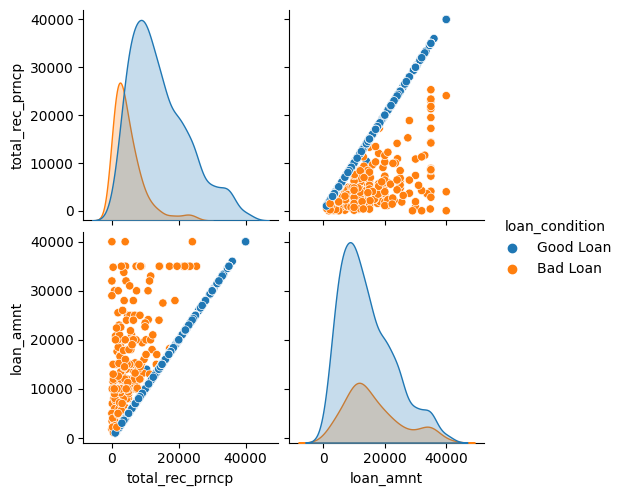

In [ ]:
sns.pairplot(drop_df[['total_rec_prncp', 'loan_condition', 'loan_amnt']].sample(n=1000, random_state=42), hue='loan_condition')

Similarly, we have:

| Feature             | Description                                                |
|---------------------|------------------------------------------------------------|
| collection_recovery_fee | Post charge off collection fee                         |
| last_pymnt_amnt       | Last total payment amount received                      |
| next_pymnt_d          | Next scheduled payment date                              |
| out_prncp             | Remaining outstanding principal for total amount funded |
| out_prncp_inv         | Remaining outstanding principal for portion of total amount funded by investors |
| recoveries            | Post charge off gross recovery                           |
| total_pymnt           | Payments received to date for total amount funded       |
|total_pymnt_inv|Payments received to date for portion of total amount funded by investors|
| total_rec_int         | Interest received to date                                 |
| total_rec_late_fee    | Late fees received to date                               |
| total_rec_prncp       | Principal received to date                               |


In [ ]:
direct_indicators = [
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'out_prncp',
    'out_prncp_inv',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
]

drop_df.drop(direct_indicators, axis=1, inplace=True)

**4 Delete repetitive and useless object variables**

| delete | reserve |
| --- | --- |
| emp_length | emp_length_int |

In [ ]:
#drop repeated features
# drop_df.drop(['loan_condition'], axis=1, inplace=True)
# drop_df.drop(['loan_status'], axis=1, inplace=True)
drop_df.drop(['emp_length'], axis=1, inplace=True)

drop_df.drop(['id','emp_title','url','title','zip_code'], axis=1, inplace=True)

# unique values a categorical variable (object) has
drop_df.select_dtypes(include=["object"]).nunique()  #include/exclude

term                      2
grade                     7
sub_grade                35
home_ownership            6
verification_status       3
issue_d                 138
loan_status               8
pymnt_plan                2
purpose                  14
addr_state               50
earliest_cr_line        630
initial_list_status       2
last_pymnt_d            134
last_credit_pull_d      123
application_type          2
hardship_flag             2
disbursement_method       2
debt_settlement_flag      2
loan_condition            2
region                    5
dtype: int64

<a name="Missing-Value-Imputation"></a>
## Missing Value Imputation

inspired by [JANIO MARTINEZ BACHMANN notebook ](https://www.kaggle.com/code/janiobachmann/lending-club-risk-analysis-and-metrics)




|index|Count|Percent|Type|Imputation method |
|---|---|---|---|---|
|tot\_coll\_amt|66689|24\.063289312260952|float64| 0 (checked the meaning, 0 suitable) |
|total\_rev\_hi\_lim|66689|24\.063289312260952|float64|0 (checked the meaning, 0 suitable) |
|tot\_cur\_bal|66689|24\.063289312260952|float64|0 (checked the meaning, 0 suitable) |
|emp\_length\_int|11101|4\.005556758317096|float64|median|
|last\_pymnt\_d|921|0\.3323230136393159|object|mode |
|revol\_util|253|0\.09128960092372086|float64|
|collections\_12\_mths\_ex\_med|145|0\.05232012701161868|float64|
|pub\_rec|29|0\.010464025402323735|float64|median |
|total\_acc|29|0\.010464025402323735|float64|median |
|acc\_now\_delinq|29|0\.010464025402323735|float64|
|open\_acc|29|0\.010464025402323735|float64|
|inq\_last\_6mths|29|0\.010464025402323735|float64|
|earliest\_cr\_line|29|0\.010464025402323735|object|
|delinq\_2yrs|29|0\.010464025402323735|float64|mean |
|last\_credit\_pull\_d|24|0\.008659883091578264|object|mode |
|annual\_income|4|0\.0014433138485963773|float64|mean |
|income\_category|4|0\.0014433138485963773|object|mode |





In [ ]:
fillna_df = drop_df.copy()

# for object variables - Get the mode of next payment date and last payment date and the last date credit amount was pulled
for column in ["last_pymnt_d", "last_credit_pull_d"]:  #, 'income_category'
    fillna_df[column] = fillna_df.groupby("region")[column].transform(lambda x: x.fillna(x.mode()))

# for numerical variables
# Get the mode on the number of accounts in which the client is delinquent
fillna_df["pub_rec"] = fillna_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
# Get the mode of the total number of credit lines the borrower has
fillna_df["total_acc"] = fillna_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

fillna_df["emp_length_int"] = fillna_df.groupby("region")["emp_length_int"].transform(lambda x: x.fillna(x.median()))

# Get the mean of the annual income depending on the region the client is located.
fillna_df["annual_inc"] = fillna_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
# Mode of credit delinquencies in the past two years.
fillna_df["delinq_2yrs"] = fillna_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# for other, fill in with zero
fillna_df.fillna(0, inplace=True)
fillna_df.isnull().sum().max() # Maximum number of nulls.

0

In [ ]:
len(fillna_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
fillna_df['loan_condition_int'].value_counts()/len(fillna_df['loan_condition_int']) * 100

loan_condition_int
0    78.14247
1    21.85753
Name: count, dtype: float64

<a name="Removing-Outliers"></a>
## Removing Outliers

Custom thresholds were used to remove outliers
(3-sigma method did not work well)

In [ ]:
#Custom thresholds
RemoveOutlier_df = fillna_df.copy()
print("Dataset before removing outlier:",RemoveOutlier_df.shape)
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['annual_inc'] <= 250000]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['dti'] <= 50]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['open_acc'] <= 40]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['total_acc'] <= 80]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_util'] <= 120]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_bal'] <= 250000]
RemoveOutlier_df.reset_index(drop=True, inplace=True)
print("Dataset after removing outlier:",RemoveOutlier_df.shape)

RemoveOutlier_df.head().transpose()

Dataset before removing outlier: (61178, 99)
Dataset after removing outlier: (60253, 99)


,0,1,2,3,4
loan_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt_inv,28000.0,10650.0,3975.0,15000.0,8000.0
term,36 months,36 months,36 months,36 months,36 months
int_rate,6.62,25.11,17.99,6.24,9.67
...,...,...,...,...,...
debt_settlement_flag,N,N,N,N,N
loan_condition_int,0,0,0,0,0
loan_condition,Good Loan,Good Loan,Good Loan,Good Loan,Good Loan
emp_length_int,10.0,10.0,2.0,8.0,10.0


<a name="Correlation-Analysis"></a>
# Correlation Analysis

Correlation analysis was performed on the variables to assess their importance and relationship to the target variable y. This provided insights into the most relevant variables for predicting good vs bad loans.

For the correlation analysis, categorical variables were label encoded to enable numeric correlation values to be calculated. While this encoding can introduce artificial numerical relationships, it provided a convenient quick view of variable importance.

For the actual model building later on, more appropriate encodings like target encoding were used for the categorical variables.

In [ ]:
target_col = target_variable = "loan_condition_int"

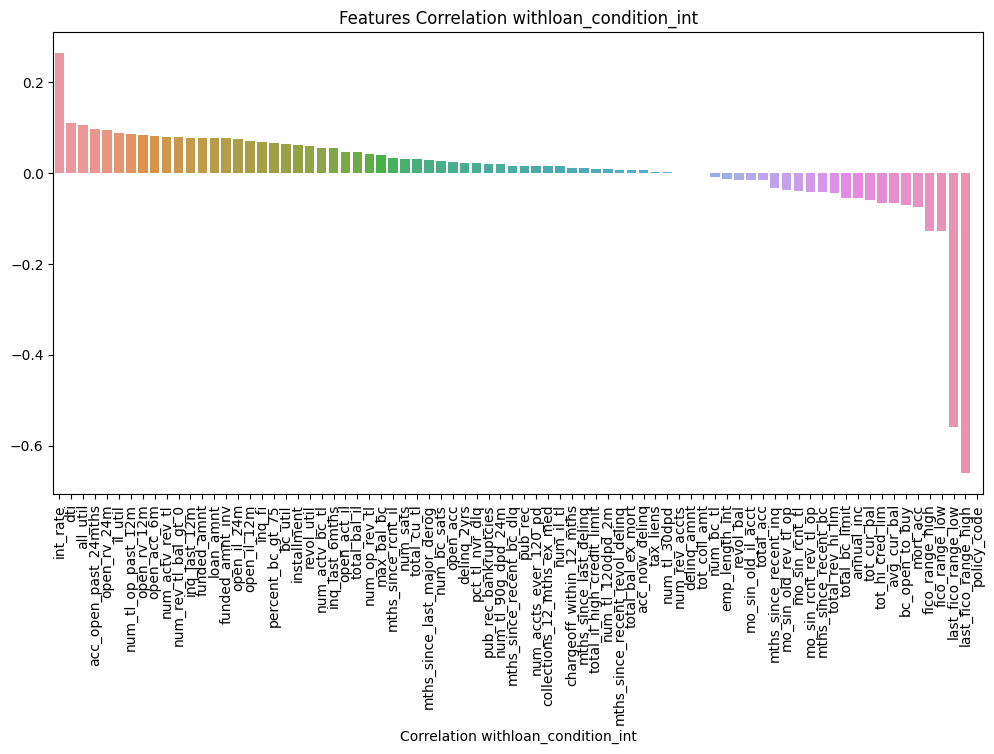

int_rate                0.263249
dti                     0.108784
all_util                0.104183
acc_open_past_24mths    0.095598
open_rv_24m             0.095068
                          ...   
fico_range_high        -0.127440
fico_range_low         -0.127441
last_fico_range_low    -0.559323
last_fico_range_high   -0.660207
policy_code                  NaN
Name: loan_condition_int, Length: 78, dtype: float64


In [ ]:
corr_df = RemoveOutlier_df.copy()

# correlation with y
correlation_with_loan_condition = corr_df.select_dtypes(include=['int64', 'float64']).corr()[target_variable]
sorted_correlation = correlation_with_loan_condition.drop(target_variable).sort_values(ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, orient='v')
plt.xlabel('Correlation with{}'.format(target_variable))
plt.title('Features Correlation with{}'.format(target_variable))
plt.xticks(rotation=90)
plt.show()
print(sorted_correlation)

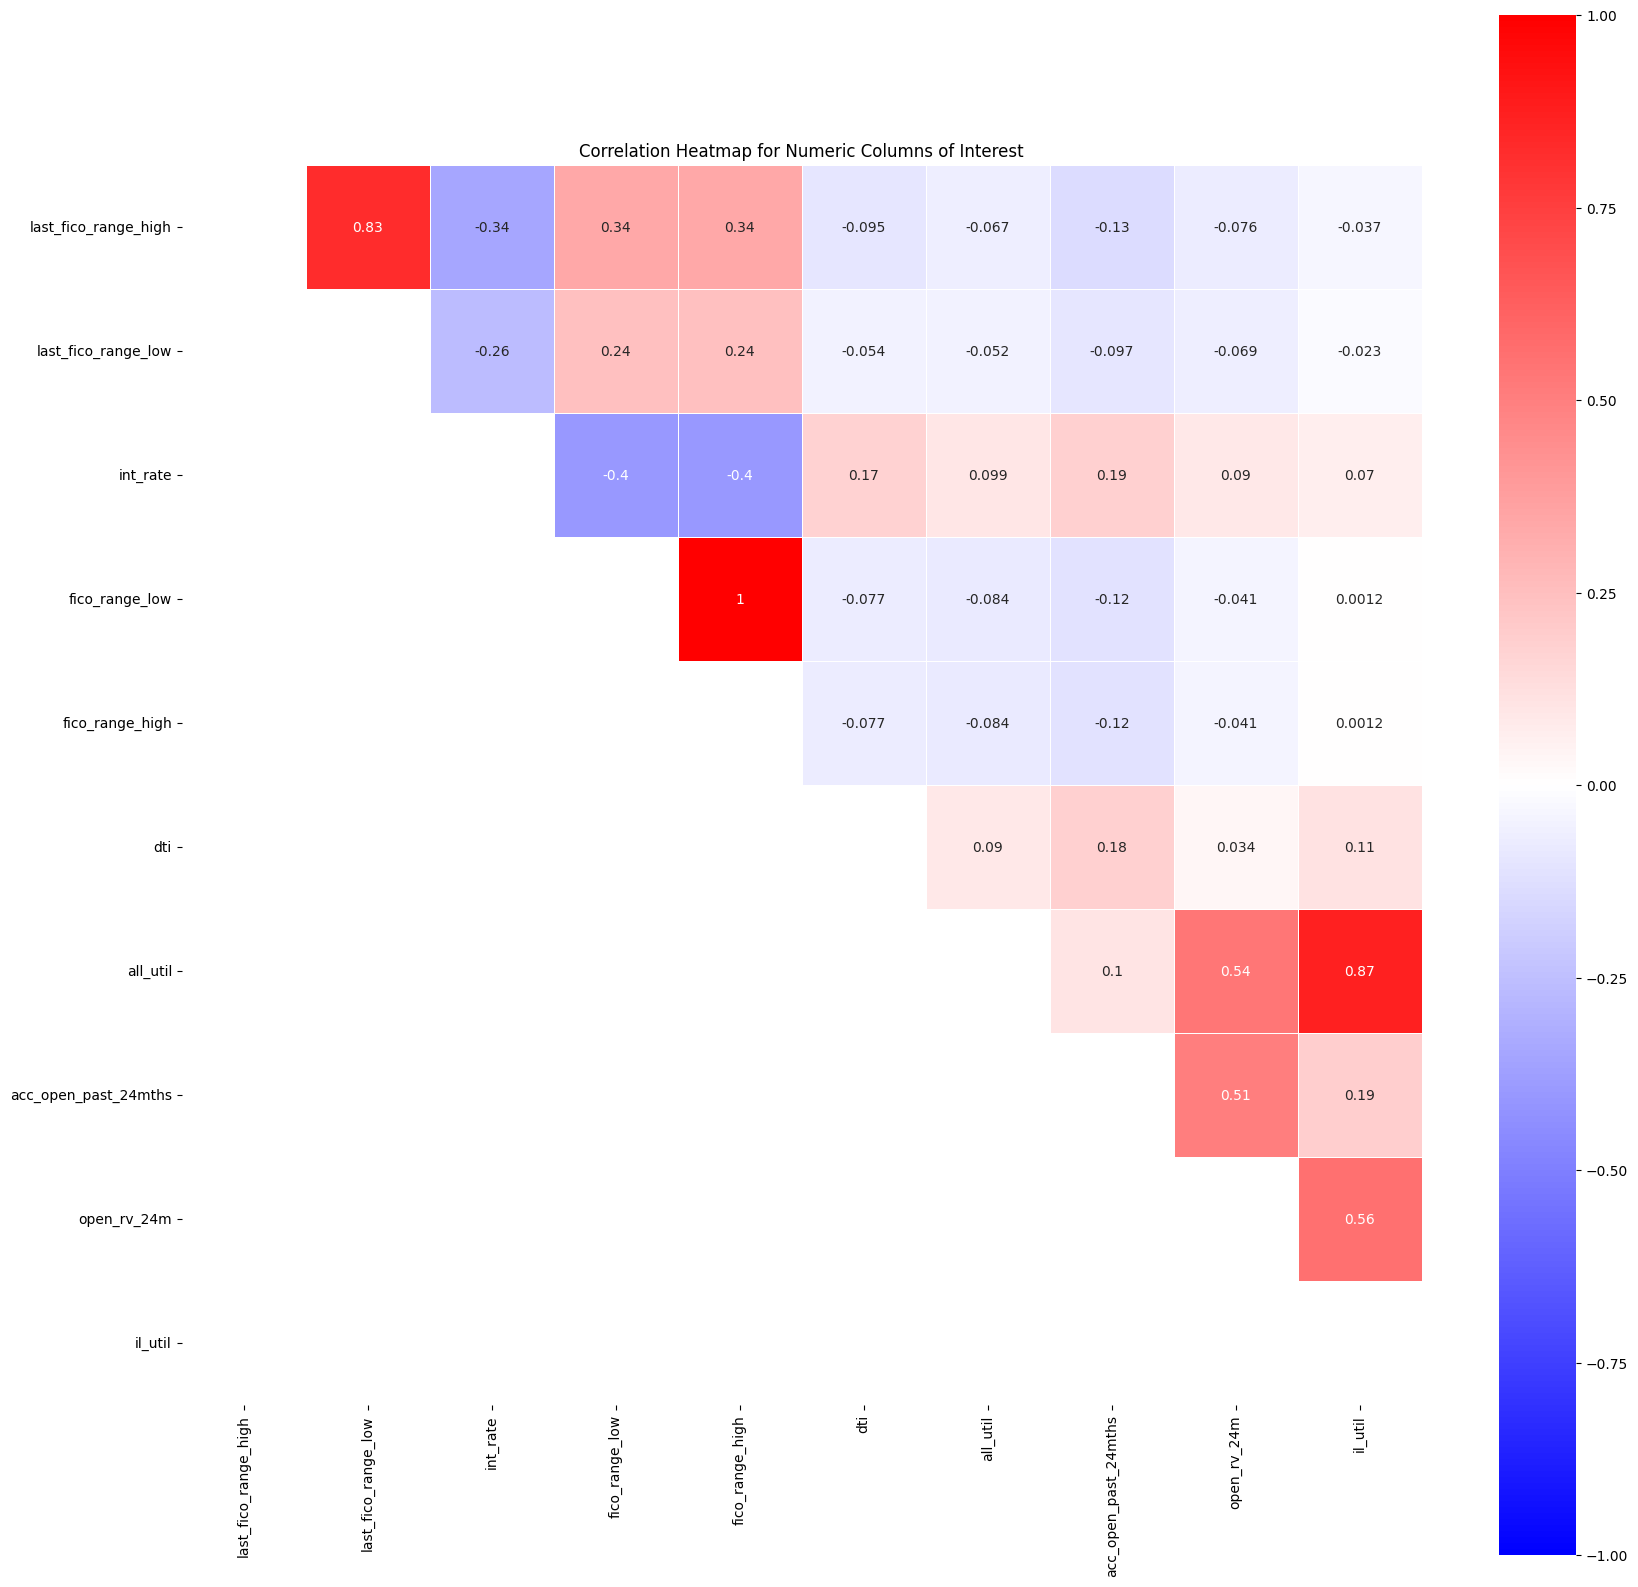

In [ ]:
# Select the variables with the highest correlation with the dependent variable and explore the correlation between them
top_variables = sorted_correlation.abs().nlargest(10).index.tolist()

plt.figure(figsize=(20, 20))
correlation_matrix = RemoveOutlier_df[top_variables].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap for Numeric Columns of Interest')
plt.show()

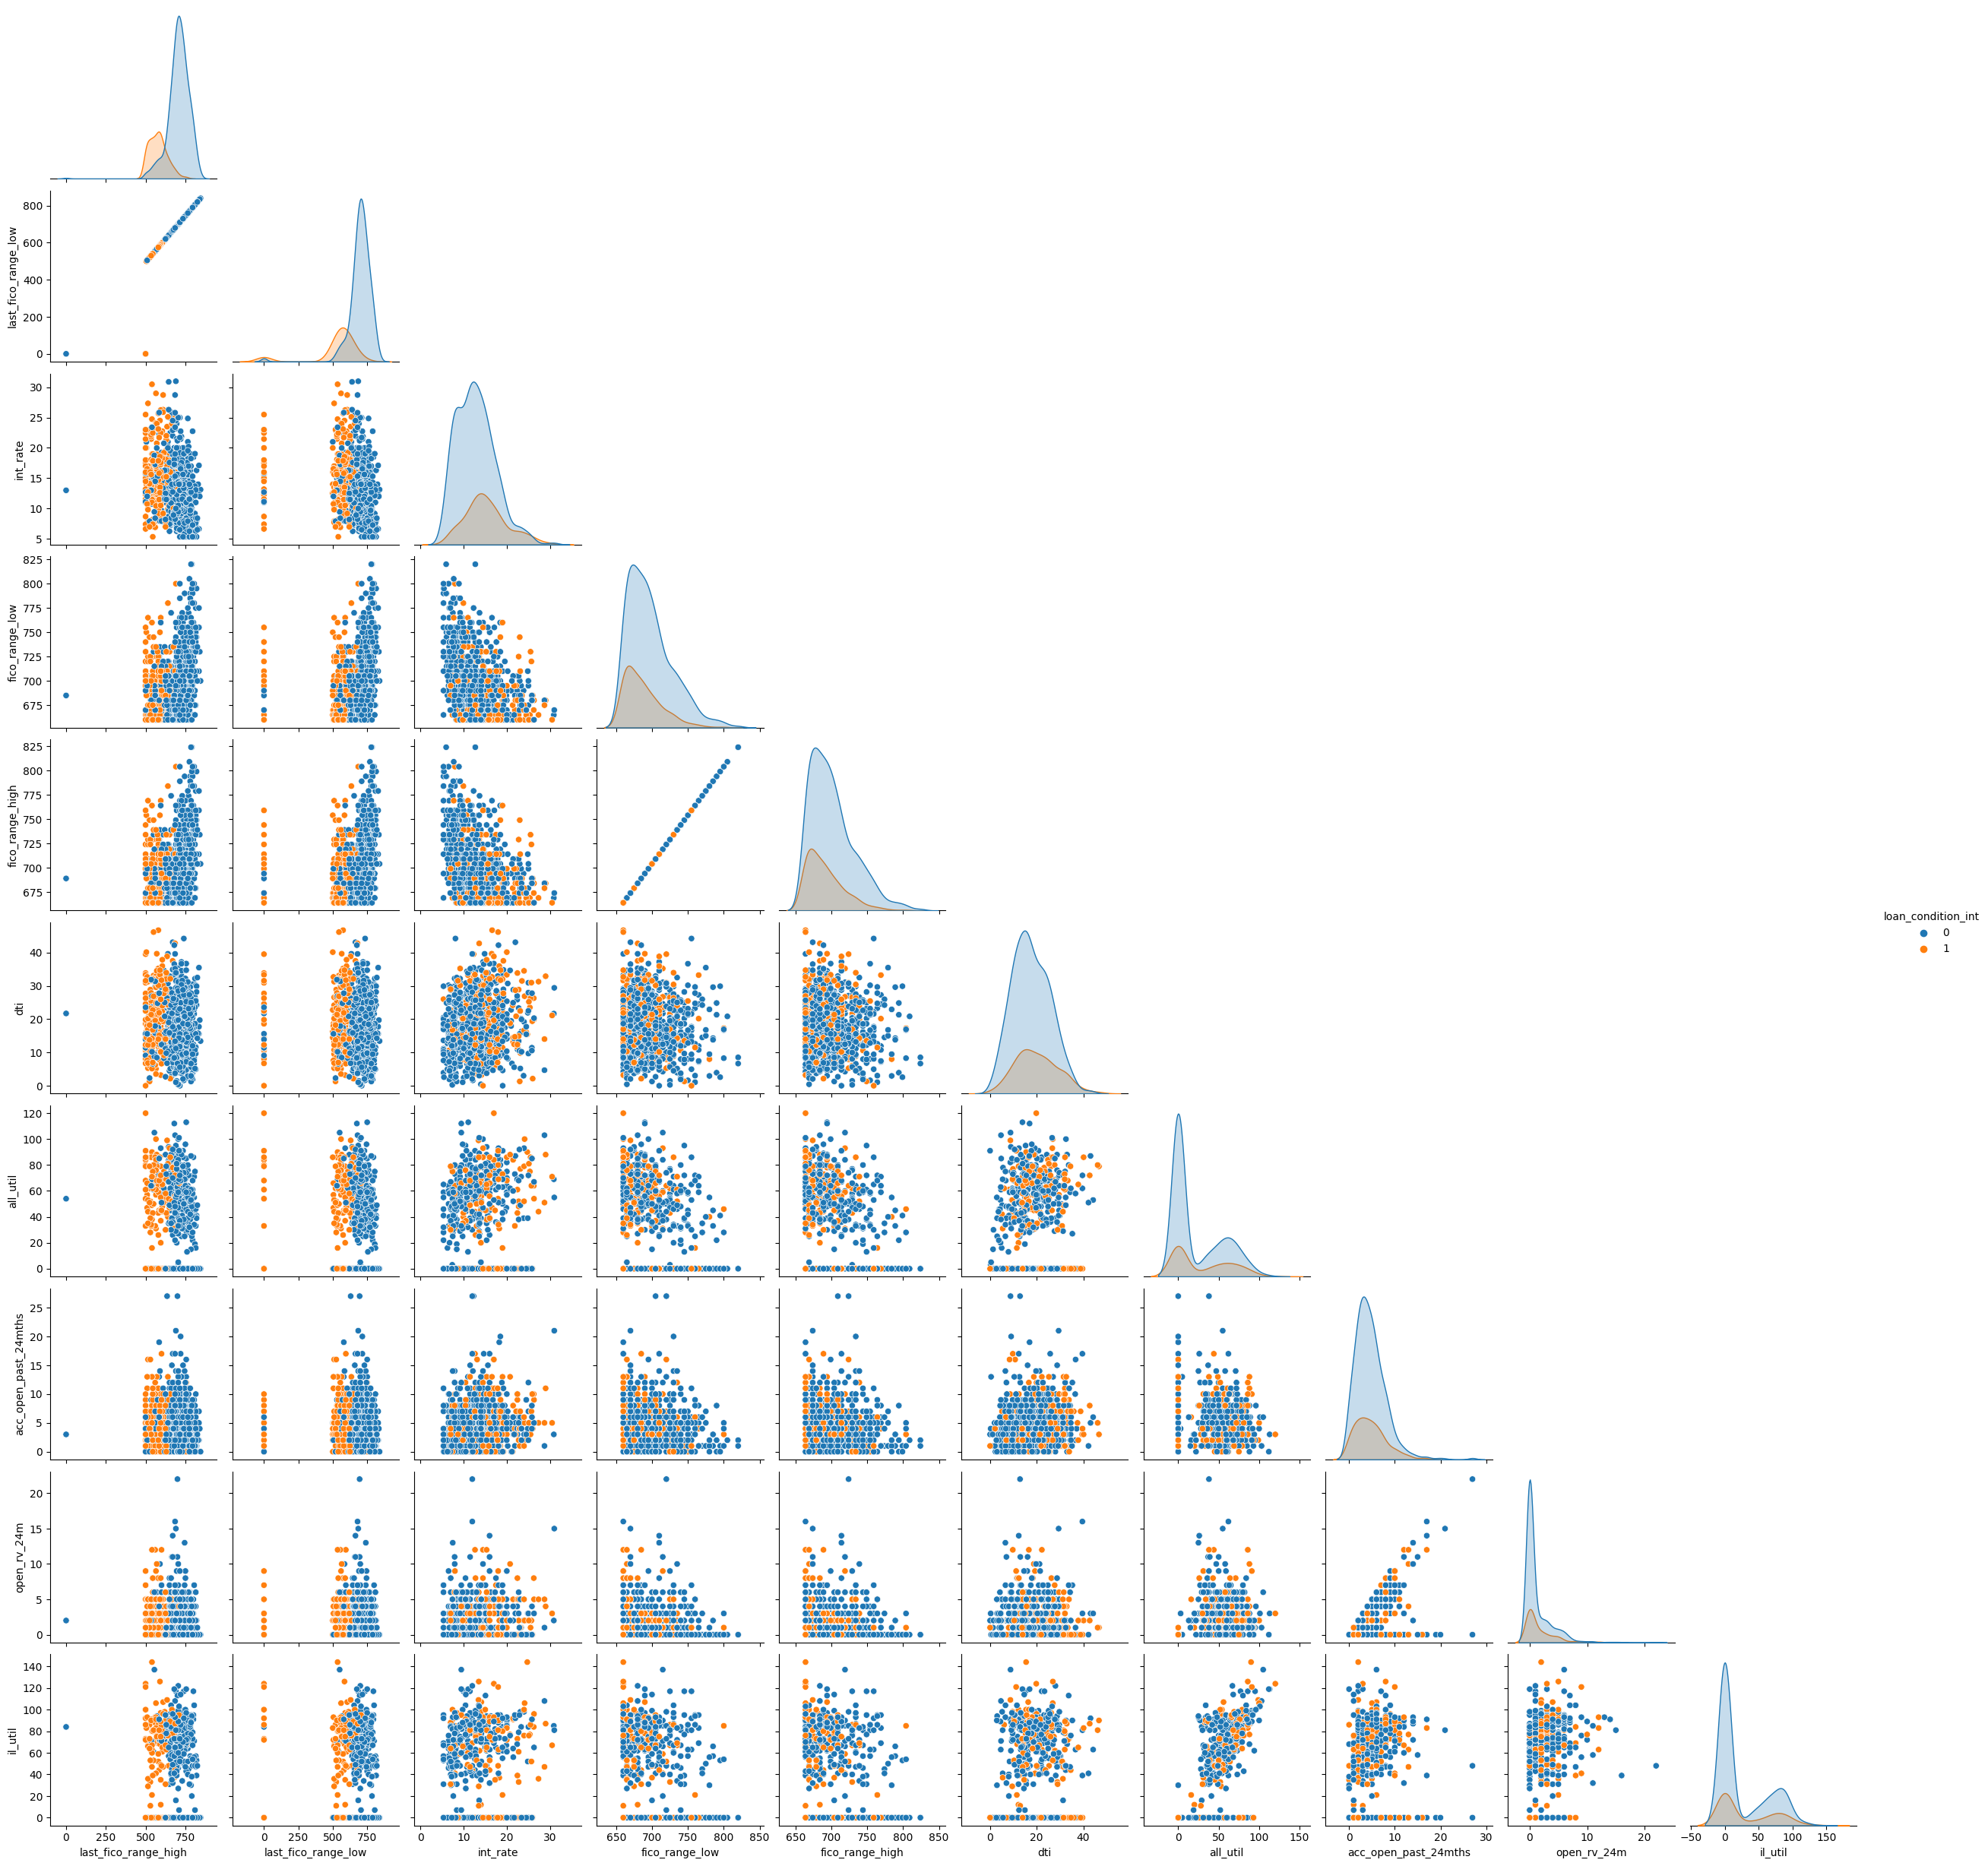

In [ ]:
# # Further, explore the specific distribution of the relationship between variables under the action of the dependent variable loan_condition_int
# # This runs a bit slowly, so run with caution
sample_corr_df = corr_df[top_variables + [target_variable]].sample(n=1000, random_state=42)
sns.pairplot(sample_corr_df,hue=target_variable, diag_kind='kde',corner=True)

<a name="Feature-Engineering"></a>
# Feature Engineering

Steps:
- **Binary Encoding** for binary (Boolean) variables
- **Target Encoding** for multivariate variables
- **Normalization** for numeric variables


Note:
In order to prevent data leakage, target encoding and normalization should only be completed on the training set, and then use the same rules to change the test set.


Something to mention:

- Train Test Split: use StrattifiedShuffleSplit to have approximately the same ratio of bad loans compared to good loans in both training and testing data. --important to imbalanced dataset
- Target Encoding: use smooth method to avoid overfitting


In [ ]:
TE_df = RemoveOutlier_df.copy()

In [ ]:
# divide variables into numerical variables and categorical variables, categorical variables are divided into binary variables and multivariate variables
original_cols = TE_df.columns

cat_cols = TE_df.select_dtypes(include=['object']).columns.tolist()
num_cols = [col for col in TE_df.select_dtypes(exclude=['object']).columns.tolist() if col not in ['id', 'loan_condition_int']]

dual_cat_cols = [col for col in cat_cols if TE_df[col].nunique()<=2]
multi_cat_cols =[col for col in cat_cols if TE_df[col].nunique()>2]

multi_cat_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'last_pymnt_d',
 'last_credit_pull_d',
 'region']

<a name="Binary-Encoding"></a>
## Binary Encoding for Binary Variables

In [ ]:
# pair all categorical features with another categorical feature
import itertools
def combine_categories(dataframe, cat_cols, expand_dim=False):
    df = dataframe.copy()
    combined = list(itertools.combinations(cat_cols, 2))
    for c1, c2 in combined:
        df.loc[:, f'{c1}__{c2}'] = df[c1].astype(str) + '_' + df[c2].astype(str)
        if expand_dim:
            cat_cols.append(f'{c1}__{c2}')
    return df, cat_cols

# binary encoding for dual_cat_cols
TE_df = pd.get_dummies(TE_df, columns=dual_cat_cols, drop_first=True)

# update dual_cat_cols
changed_columns = [col for col in TE_df.columns if col not in original_cols]
dual_cat_cols = changed_columns

TE_df.head().transpose()

,0,1,2,3,4
loan_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt_inv,28000.0,10650.0,3975.0,15000.0,8000.0
int_rate,6.62,25.11,17.99,6.24,9.67
installment,859.71,424.07,143.69,457.97,256.9
...,...,...,...,...,...
application_type_Joint App,False,False,False,False,False
hardship_flag_Y,False,False,False,False,False
disbursement_method_DirectPay,False,False,False,False,False
debt_settlement_flag_Y,False,False,False,False,False


## 🔪Train Test Split

The purpose of the code below is to have the same ratio across our training and test sets.

This should better be done before target encoding and normalization to avoid data leakage.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #Specify test_size to account for 20%

for train_set, test_set in stratified.split(TE_df, TE_df[target_col]):
    stratified_train = TE_df.loc[train_set]
    stratified_test = TE_df.loc[test_set]

train_df = stratified_train
test_df = stratified_test

# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

print(train_df[target_col].value_counts()/len(TE_df))
print(test_df[target_col].value_counts()/len(TE_df))
train_df.shape

loan_condition_int
0    0.625098
1    0.174896
Name: count, dtype: float64
loan_condition_int
0    0.156291
1    0.043716
Name: count, dtype: float64


(48202, 99)

In [ ]:
# separates the y(target variables) and X(features) for the training and testing datasets

train_y = train_df[[target_col]]
test_y = test_df[[target_col]]

train_X = train_df.drop(target_col, axis=1, inplace=False)
test_X = test_df.drop(target_col, axis=1, inplace=False)

train_X.shape

(48202, 98)

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `train_X` | `train_y` |
| test | `test_X` | `test_y` |

<a name="Target-Encoding"></a>
## Target Encoding for Multicategorical Variables

In [ ]:
# Create a data set containing only multi-categorical variables
multi_cat_train_X = train_X[multi_cat_cols]
multi_cat_test_X = test_X[multi_cat_cols]

# Target encode categorical variables with smoothing method (on train set)
encoder = TargetEncoder(smoothing=0.2)
encoder.fit(multi_cat_train_X, train_y)

# Apply the same encoding rules on train and test set
encoded_multi_cat_train_X = encoder.transform(multi_cat_train_X)
encoded_multi_cat_test_X = encoder.transform(multi_cat_test_X)

encoded_train_X = pd.concat([train_X.drop(columns=multi_cat_cols), encoded_multi_cat_train_X], axis=1)
encoded_test_X = pd.concat([test_X.drop(columns=multi_cat_cols), encoded_multi_cat_test_X], axis=1)

encoded_train_X.head().transpose()

,0,1,2,3,4
loan_amnt,13500.0,20000.0,24000.0,15000.0,10200.0
funded_amnt,13500.0,20000.0,24000.0,15000.0,10200.0
funded_amnt_inv,13500.0,20000.0,24000.0,15000.0,10200.0
int_rate,12.12,6.49,12.12,11.44,13.33
installment,449.17,612.89,798.52,494.22,345.31
...,...,...,...,...,...
addr_state,0.203125,0.220217,0.214724,0.208707,0.163669
earliest_cr_line,0.230159,0.224299,0.184211,0.246862,0.231441
last_pymnt_d,0.220036,0.180867,0.212121,0.170107,0.180867
last_credit_pull_d,0.144928,0.144928,0.774515,0.100982,0.295515


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `encoded_train_X` | `train_y` |
| test | `encoded_test_X` | `test_y` |

<a name="Normalization"></a>
## Normalization for Numeric Variables

In [ ]:
scaler = StandardScaler()

# Fit and apply normalization on the training set
standardized_train_X = encoded_train_X.copy()
standardized_train_X[num_cols] = scaler.fit_transform(encoded_train_X[num_cols])

# Apply the same normalization rules on the test set
standardized_test_X = encoded_test_X.copy()
standardized_test_X[num_cols] = scaler.transform(encoded_test_X[num_cols])

standardized_train_X.head().transpose()

,0,1,2,3,4
loan_amnt,-0.098858,0.654422,1.11798,0.074976,-0.481292
funded_amnt,-0.098136,0.655446,1.119188,0.075768,-0.480723
funded_amnt_inv,-0.094965,0.658057,1.121455,0.078809,-0.477269
int_rate,-0.253318,-1.435592,-0.253318,-0.396115,0.000777
installment,0.050257,0.682655,1.399684,0.22427,-0.350921
...,...,...,...,...,...
addr_state,0.203125,0.220217,0.214724,0.208707,0.163669
earliest_cr_line,0.230159,0.224299,0.184211,0.246862,0.231441
last_pymnt_d,0.220036,0.180867,0.212121,0.170107,0.180867
last_credit_pull_d,0.144928,0.144928,0.774515,0.100982,0.295515


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `standardized_train_X` | `train_y` |
| test | `standardized_test_X` | `test_y` |

<a name="Dealing-with-Imbalanced-Dataset"></a>
# Dealing with Imbalanced Dataset
Our data set is an unbalanced data set (80% good loans). What we are more concerned about is the accuracy of bad loan prediction, so balancing the data is particularly important.



Balanced data can be oversampled or undersampled. Random undersampling and SMOTE (oversampling) methods are provided below. Since the data set is very large, the data set after undersampling is used subsequently. In comparison, the authenticity of the data is guaranteed.

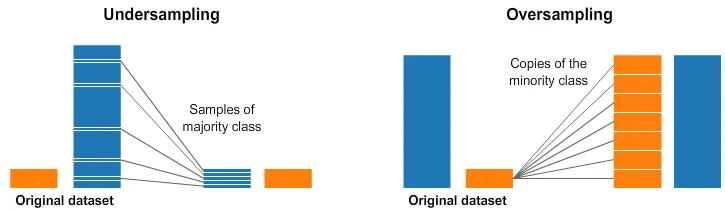

Undersamping our data

In [ ]:
undersampler = RandomUnderSampler(random_state=42)

# Undersampling the training set
standardized_train_X_undersample, train_y_undersample = undersampler.fit_resample(standardized_train_X, train_y)


print('standardized_train_X_undersample.shape',standardized_train_X_undersample.shape)
pd.value_counts(train_y_undersample.loan_condition_int).to_frame()

standardized_train_X_undersample.shape (21076, 98)


,count
loan_condition_int,
0,10538
1,10538


until now (undersampling), we have：


| train vs test | X | y |
| --- | --- | --- |
| train | standardized_train_X_undersample | train_y_undersample |
| test | standardized_test_X | test_y |

Or you can use SMOTE. After testing, the effect is similar to the model after Undersampling.

In [ ]:
# smote = SMOTE(random_state=42)

# # oversampling the training set
# train_X_SMOTE, train_y_SMOTE = smote.fit_resample(standardized_train_X, train_y)

<a name="Feature-Selection"></a>
# Feature Selection


*   Filter
*   Wrapper



In [ ]:
selector = VarianceThreshold(threshold=1)
selector.fit(standardized_train_X_undersample)

filtered_feature_names = standardized_train_X_undersample.columns[selector.get_support()]
standardized_train_X_undersample_filtered = standardized_train_X_undersample[filtered_feature_names]

standardized_train_X_undersample_filtered.shape

(21076, 48)

In [ ]:
#modify this if you want to use SMOTE
to_wrap_train_X = standardized_train_X_undersample_filtered.copy()
train_y = train_y_undersample.copy()

In [ ]:
nfeatures = len(to_wrap_train_X.columns)
nfeatures

48

Stepwise selection wrapper will take a lot of time, so you can skip it directly and use the results I got after running it, as follows:

In [ ]:
vars_final = ['delinq_2yrs',
 'last_fico_range_high',
 'last_fico_range_low',
 'acc_now_delinq',
 'open_acc_6m',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'all_util']

Or if you have time you can run it yourself （Ctrl+/ Uncomment and run）

In [ ]:
# %%time
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# nfeatures = len(to_wrap_train_X.columns)
# clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
# sfs = SFS(clf, k_features=nfeatures, forward=True, verbose=2, cv=2, n_jobs=-1)
# sfs.fit(to_wrap_train_X, train_y)

# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
# vars_FS

In [ ]:
# vars_final = list(vars_FS.loc[15, 'feature_names'])
# vars_final

In [ ]:
# fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(8, 5))
# plt.xticks(np.arange(0, len(to_wrap_train_X.columns), step=5))

# # plt.ylim([0.9, 1.0])
# plt.xlim(0,len(to_wrap_train_X.columns))
# plt.title('Stepwise Selection')
# plt.grid()
# plt.show()

In [ ]:
# Use wrapper to reduce variables
wrapped_train_X = to_wrap_train_X.filter(vars_final, axis=1)
wrapped_test_X = standardized_test_X.filter(vars_final, axis=1)


print("final train/test X shape (target encoded):", wrapped_train_X.shape, wrapped_test_X.shape)
print("final train/test y shape:", train_y.shape, test_y.shape)

final train/test X shape (target encoded): (21076, 9) (12051, 9)
final train/test y shape: (21076, 1) (12051, 1)


In [ ]:
wrapped_train_X.head()

,delinq_2yrs,last_fico_range_high,last_fico_range_low,acc_now_delinq,open_acc_6m,total_bal_il,il_util,open_rv_12m,all_util
23121,-0.363123,0.902858,0.652201,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
15658,1.952124,0.718628,0.539465,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
47801,-0.363123,1.578370,1.065566,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
28508,0.794500,-1.246497,-0.663051,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
5866,-0.363123,1.087089,0.764937,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | wrapped_train_X | train_y |
| test | wrapped_test_X | test_y |

<a name="Model-Building"></a>
# Model Building

Models:


*   Logistic Regression
*   Decision Tree
*   K Nearest Neighbors
*   Random Forest
*   Gaussian Naive Bayes
*   Light GBM
*   XGBoost
*   Gradient Boosting
*   Neural Network

**5-fold Cross Validation**: The model was trained on the training set and 5-fold cross-validation was used to assess model accuracy during training.



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def plot_confusion_matrix(mean_conf_matrix, xtick_labels=None, ytick_labels=None):
    fig, axes = plt.subplots(figsize=(8, 6))
    default_style = sns.axes_style()
    # sns.set(font_scale=1.5)
    ax = sns.heatmap(mean_conf_matrix.T, annot=True, cmap='Blues', fmt=".1f",annot_kws={"size": 18})
    if xtick_labels:
        ax.set_xticklabels(xtick_labels)
    if ytick_labels:
        ax.set_yticklabels(ytick_labels)


    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Label')
    ax.axis('equal')
    plt.title('Mean Confusion Matrix')
    sns.set_style(default_style)
    plt.show()

def calculate_scores(model, X_trn, y_trn, X_tst, y_tst):
    """Calculate various classification scores on the test set"""
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    accuracy = accuracy_score(y_tst, y_pred)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_tst, y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_tst, y_pred)
    recall = recall_score(y_tst, y_pred)
    f1 = f1_score(y_tst, y_pred)

    y_pred_proba = model.predict_proba(X_tst)[:,1]
    auc = roc_auc_score(y_tst, y_pred_proba)

    mask = y_tst['loan_condition_int'].astype(bool).values
    churn = y_pred_proba[mask]
    not_churn = y_pred_proba[~mask]
    ks = sps.ks_2samp(churn, not_churn)[0]

    return accuracy, auc, ks, conf_matrix, precision, recall, f1

def fit_first_level(models, X_trn, y_trn, X_tst):
    """
    Prepare first-level model fitting for stacking. Only used during model stacking.
    Output the predicted probabilities of the first-level models as features for the stacking model.
    """
    # Create dataframes to store predictions of the first-level models
    X2_trn = np.zeros((len(X_trn), 2 * len(models)))
    X2_tst = np.zeros((len(X_tst), 2 * len(models)))

    for i, model in enumerate(models.values()):
        print("Stacking with", model)

        model.fit(X_trn, y_trn)
        y_trn_pred_proba = model.predict_proba(X_trn)
        y_tst_pred_proba = model.predict_proba(X_tst)

        X2_trn[:, i*2:(i+1)*2] = y_trn_pred_proba
        X2_tst[:, i*2:(i+1)*2] = y_tst_pred_proba

    return X2_trn, X2_tst

def calculate_cv_scores(model, X, y, cv=5, stacking=False, models=None, verbose=False):
    """Calculate average k-fold cross-validated classification scores"""
    kf = KFold(n_splits=cv, shuffle=True)
    accuracy_scores = []
    auc_scores = []
    ks_scores = []
    conf_matrices = []  # Store confusion matrices for each fold
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fold_count = 0

    for train_index, test_index in kf.split(X):
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]

        if stacking:
            # smote = False
            X_trn, X_tst = fit_first_level(models, X_trn, y_trn, X_tst)

        accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, X_tst, y_tst)
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        ks_scores.append(ks)
        conf_matrices.append(conf_matrix)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # if verbose:
        #     print(f"Fold {fold_count} accuracy, auc, ks:", accuracy, auc, ks)

        fold_count += 1

    # mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0) #/ np.sum(np.mean(conf_matrices, axis=0)))
    print(f"Mean Confusion Matrix for Model:\n", mean_conf_matrix)
    plot_confusion_matrix(mean_conf_matrix, xtick_labels=['Good Loan', 'Bad Loan'], ytick_labels=['Good Loan', 'Bad Loan'])

    return np.mean(accuracy_scores), np.mean(auc_scores), np.mean(ks_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

def fit_models_summary(models, X, y, cv=5, smote = False,undersample = False):
    """
    Calculate average k-fold cross-validated classification scores for multiple models.
    Generate a summary dataframe.
    """
    baseline = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

    for name, model in models.items():
        # accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv, smote=False)
        # baseline.loc[name] = [accuracy, auc, ks, None, precision, recall, f1]

        accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv)

        if smote:
            baseline.loc["{} (SMOTE)".format(name)] = [accuracy, auc, ks, precision, recall, f1]
        if undersample:
            baseline.loc["{} (undersample)".format(name)] = [accuracy, auc, ks, precision, recall, f1]

        print(f"{name} processed")

    return baseline

In [ ]:
mss=60
msl=int(mss/2)

models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
     'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
     'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10)),
# #     'Support Vector Machine': SVC()
}

Mean Confusion Matrix for Model:
 [[1859.2  248.4]
 [ 299.2 1808.4]]


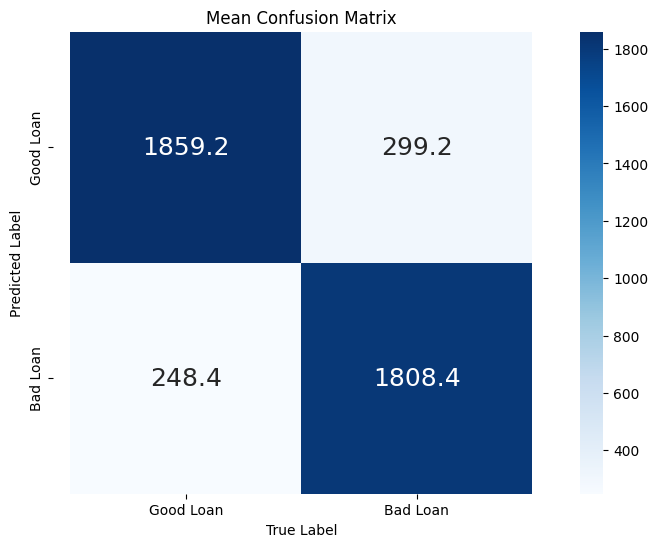

Logistic Regression processed
Mean Confusion Matrix for Model:
 [[1818.2  289.4]
 [ 259.2 1848.4]]


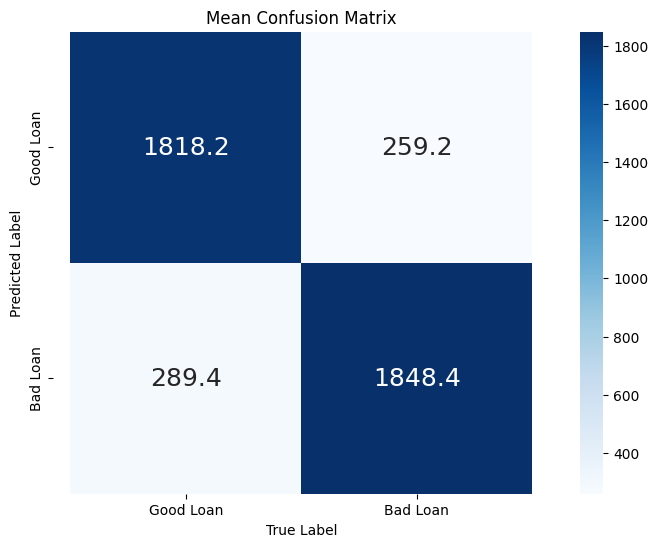

Decision Tree processed
Mean Confusion Matrix for Model:
 [[1987.8  119.8]
 [ 909.4 1198.2]]


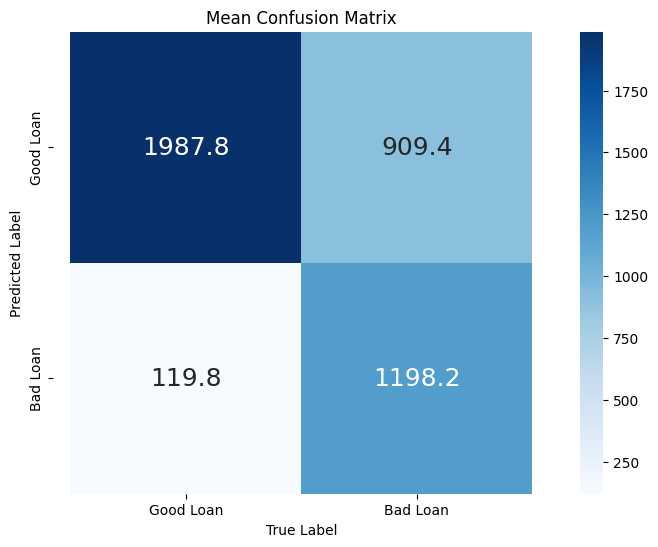

K Nearest Neighbors processed
Mean Confusion Matrix for Model:
 [[1824.2  283.4]
 [ 259.8 1847.8]]


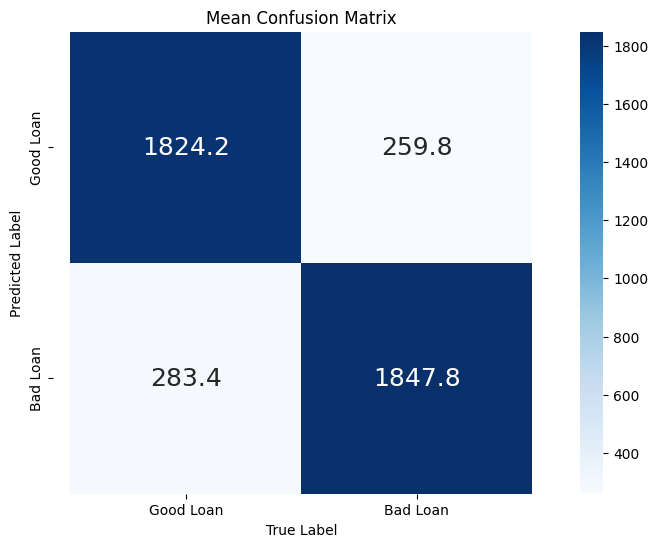

Random Forest processed
Mean Confusion Matrix for Model:
 [[1961.2  146.4]
 [ 713.2 1394.4]]


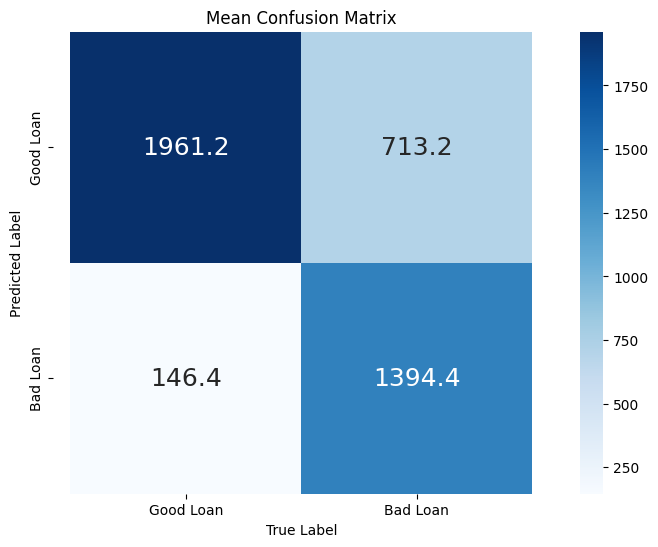

Gaussian Naive Bayes processed
Mean Confusion Matrix for Model:
 [[1833.   274.6]
 [ 259.6 1848. ]]


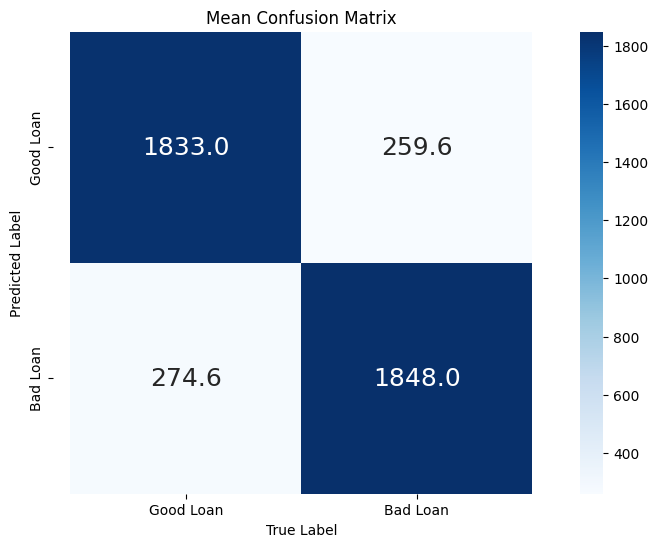

Light GBM processed
Mean Confusion Matrix for Model:
 [[1835.4  272.2]
 [ 261.4 1846.2]]


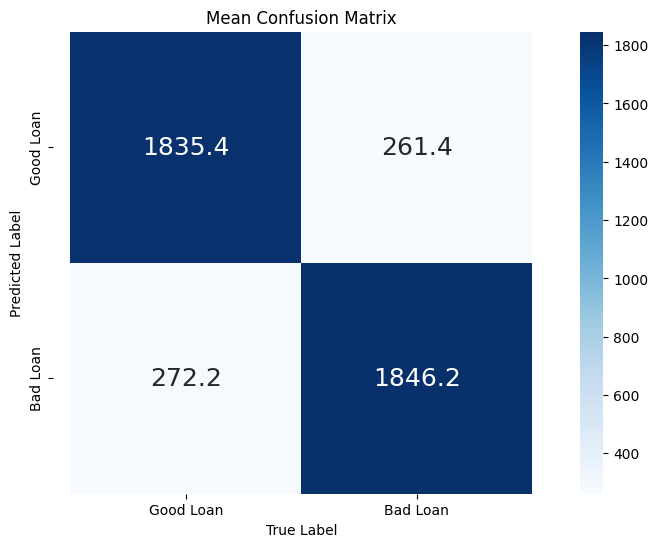

XGBoost processed
Mean Confusion Matrix for Model:
 [[1833.6  274. ]
 [ 257.8 1849.8]]


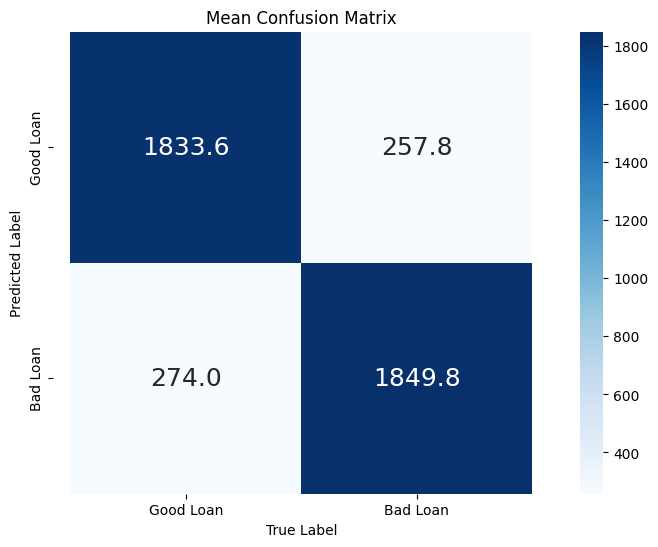

Gradient Boosting processed
Mean Confusion Matrix for Model:
 [[1822.   285.6]
 [ 249.  1858.6]]


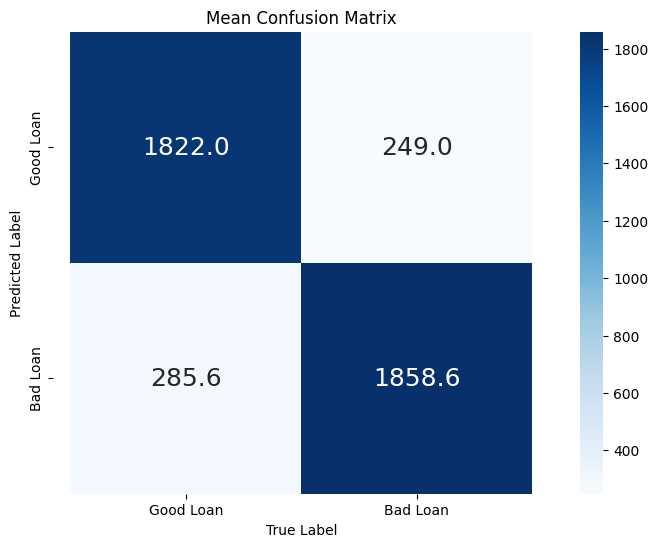

Neural Network processed


In [ ]:
# test baseline models on undersampling dataset
baseline_tgt = fit_models_summary(models, wrapped_train_X, train_y, undersample=True)

In [ ]:
baseline_tgt

,accuracy,auc,ks,precision,recall,f1
Logistic Regression (undersample),0.870089,0.930800,0.747632,0.879209,0.858008,0.868475
Decision Tree (undersample),0.869852,0.929403,0.744934,0.864601,0.876960,0.870697
K Nearest Neighbors (undersample),0.755836,0.781484,0.532835,0.909042,0.568432,0.699382
Random Forest (undersample),0.871133,0.932275,0.746266,0.867161,0.876748,0.871854
Gaussian Naive Bayes (undersample),0.796070,0.913344,0.692686,0.905197,0.661765,0.764063
Light GBM (undersample),0.873268,0.934674,0.751149,0.870652,0.876886,0.873723
XGBoost (undersample),0.873411,0.933569,0.749501,0.871528,0.876043,0.873764
Gradient Boosting (undersample),0.873838,0.934809,0.750279,0.870892,0.877613,0.874237
Neural Network (undersample),0.873173,0.933904,0.749999,0.866810,0.881879,0.874239


<a name="Model-Stacking"></a>
# Model Bagging and Stacking

Bagging

In [ ]:
models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
    #  'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
    #  'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10))
}

In [ ]:
performance_df = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

bagging_models = {}

for model_name, model in models.items():
    print("processing: ", model_name)
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)

    # Training Bagging model
    bagging_model.fit(wrapped_train_X, train_y)

    bagging_models[model_name + '_bagging'] = bagging_model
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    performance_dict = {
        'accuracy': accuracy,
        'auc': auc,
        'ks': ks,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    performance_df.loc[model_name + ' (bagging)'] = performance_dict

performance_df

processing:  Logistic Regression
processing:  Decision Tree
processing:  Random Forest
processing:  Light GBM
processing:  XGBoost
processing:  Gradient Boosting
processing:  Neural Network


,accuracy,auc,ks,precision,recall,f1
Logistic Regression (bagging),0.873206,0.928002,0.736792,0.662839,0.854594,0.746600
Decision Tree (bagging),0.868891,0.930070,0.741244,0.648954,0.871678,0.744005
Random Forest (bagging),0.868891,0.930468,0.742797,0.648200,0.875095,0.744750
Light GBM (bagging),0.869720,0.931759,0.742550,0.650538,0.872817,0.745460
XGBoost (bagging),0.869388,0.931695,0.742080,0.649718,0.873197,0.745060
Gradient Boosting (bagging),0.869471,0.931582,0.741977,0.650071,0.872437,0.745015
Neural Network (bagging),0.865737,0.932257,0.744672,0.639714,0.883068,0.741946


Stacking

Stacking with LogisticRegression()
Stacking with DecisionTreeClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=60)
Stacking with RandomForestClassifier(max_depth=10, n_estimators=20)
Stacking with LGBMClassifier(max_depth=3, n_estimators=50)
Stacking with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, r

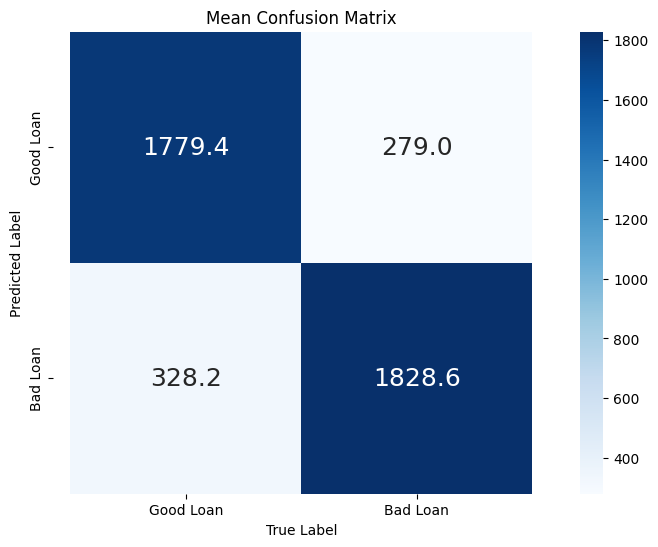

Stacking baseline:
Accuracy: 0.8559494756460729
AUC: 0.9145645535588155
recall: 0.8676096260246597
CPU times: user 37.4 s, sys: 3.18 s, total: 40.6 s
Wall time: 35 s


In [ ]:
%%time
stack_model = XGBClassifier(max_depth = 3)
accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(stack_model, wrapped_train_X, train_y,
                                        stacking = True, models = models,
                                        verbose = True)
print('Stacking baseline:')
print('Accuracy:', accuracy)
print('AUC:', auc)
print('recall:', recall)

<a name="Model-Evaluation"></a>
# Model Evaluation on Test Set
**Performance on test set:** models were evaluated on the held-out test set to obtain true test accuracy.

In [ ]:
holdout_summary = pd.DataFrame(columns = ['accuracy','auc','ks','precision','recall','f1'])

X_trn, y_trn = wrapped_train_X, train_y

for name, model in models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, wrapped_test_X, test_y)
    holdout_summary.loc[name] = [accuracy, auc, ks, precision, recall, f1]

X2_trn, X2_tst = fit_first_level(models, wrapped_train_X, train_y, wrapped_test_X)


# add bagging model performance
for model_name, bagging_model in bagging_models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    holdout_summary.loc[model_name] = [accuracy, auc, ks, precision, recall, f1]


# add stack model performance
stack_model = XGBClassifier()
accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(stack_model, X2_trn, train_y, X2_tst, test_y)
holdout_summary.loc['Stacking Model (XGB)'] = [accuracy, auc, ks, precision, recall, f1]

Stacking with LogisticRegression()
Stacking with DecisionTreeClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=60)
Stacking with RandomForestClassifier(max_depth=10, n_estimators=20)
Stacking with LGBMClassifier(max_depth=3, n_estimators=50)
Stacking with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, r

In [ ]:
holdout_summary

,accuracy,auc,ks,precision,recall,f1
Logistic Regression,0.872708,0.928085,0.737320,0.661670,0.854594,0.745858
Decision Tree,0.868061,0.925354,0.741518,0.646794,0.873197,0.743134
Random Forest,0.867148,0.929849,0.739723,0.644637,0.873956,0.741982
Light GBM,0.870218,0.931511,0.742125,0.651902,0.871678,0.745939
XGBoost,0.869554,0.931348,0.740968,0.650681,0.870539,0.744722
Gradient Boosting,0.870218,0.931429,0.742247,0.651730,0.872437,0.746104
Neural Network,0.865903,0.931422,0.743989,0.640453,0.881169,0.741771
Logistic Regression_bagging,0.873206,0.928002,0.736792,0.662839,0.854594,0.746600
Decision Tree_bagging,0.868891,0.930070,0.741244,0.648954,0.871678,0.744005
Random Forest_bagging,0.868891,0.930468,0.742797,0.648200,0.875095,0.744750


**Conclusion**
- The performance scores on the hold-out set are nearly the same with the cross-validated scores on the training set. This is a good sign that the models don't overfit.
- The performance of the models are very close to each other. For computation and interpretability concerns, the Logistic Regression/ Decision Tree/ Random Forest model with undersampling method is recommended.